In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
from torchinfo import summary

from dataset import MnistDataset
import training as f
from vae.vanilla_vae import VAE

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1050 Ti'

In [3]:
BATCH_SIZE = 64

N_PIXELS = 28 * 28
LATENT_SIZE = 16
N_NEURONS = 32

LR = 1e-3
EPOCHS = 30
MAX_PATIENCE = 6

In [4]:
t = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.1307,), (0.3081,))
    ]
)

train_data = MnistDataset('train', t)
val_data = MnistDataset('val', t)
test_data = MnistDataset('test', t)

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [5]:
min_ = 1
max_ = -1
for batch in train_loader:
    if batch.min() < min_:
        min_ = batch.min()
    elif batch.max() > max_:
        max_ = batch.max()

display(min_)
max_

tensor(0.)

tensor(1.)

In [6]:
result_dir = 'results/'
name = 'vae'

In [7]:
encoder = nn.Sequential(
    nn.Linear(N_PIXELS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, 2 * LATENT_SIZE)
).to(device)

decoder = nn.Sequential(
    nn.Linear(LATENT_SIZE, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, N_PIXELS), nn.Sigmoid()
).to(device)

model = VAE(encoder, decoder, LATENT_SIZE).to(device)

# Print summary
print("ENCODER:\n", summary(encoder, (N_PIXELS,)))
print("\nDECODER:\n", summary(decoder, (LATENT_SIZE,)))

ENCODER:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32]                      --
├─Linear: 1-1                            [32]                      25,120
├─LeakyReLU: 1-2                         [32]                      --
├─Linear: 1-3                            [32]                      1,056
├─LeakyReLU: 1-4                         [32]                      --
├─Linear: 1-5                            [32]                      1,056
Total params: 27,232
Trainable params: 27,232
Non-trainable params: 0
Total mult-adds (M): 0.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.11
Estimated Total Size (MB): 0.11

DECODER:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [784]                     --
├─Linear: 1-1                            [32]                      544
├─LeakyReLU: 1-2                         [32]    

In [8]:
optimizer = torch.optim.Adamax(model.parameters(), lr=LR)

nll_val = f.training(device, result_dir + name, MAX_PATIENCE, EPOCHS, model, optimizer, train_loader, val_loader)

Epoch: 0, val_loss=0.0010308700129389762
Epoch: 1, val_loss=0.0009337558913975954
Epoch: 2, val_loss=0.0009014493614435196
Epoch: 3, val_loss=0.0008405092559754849
Epoch: 4, val_loss=0.0007749879125505686
Epoch: 5, val_loss=0.0007374835662543774
Epoch: 6, val_loss=0.0007078164275735616
Epoch: 7, val_loss=0.0006854162961244583
Epoch: 8, val_loss=0.0006698739316314459
Epoch: 9, val_loss=0.000655629151314497
Epoch: 10, val_loss=0.0006430338341742754
Epoch: 11, val_loss=0.000632116924226284
Epoch: 12, val_loss=0.0006218499671667814
Epoch: 13, val_loss=0.0006117028702050447
Epoch: 14, val_loss=0.0006022052004933358
Epoch: 15, val_loss=0.0005956239849328994
Epoch: 16, val_loss=0.0005901817318052054
Epoch: 17, val_loss=0.0005842342030256987
Epoch: 18, val_loss=0.0005779196638613939
Epoch: 19, val_loss=0.0005729068741202355
Epoch: 20, val_loss=0.0005694068603217602
Epoch: 21, val_loss=0.0005664542380720377
Epoch: 22, val_loss=0.0005629471719264984
Epoch: 23, val_loss=0.0005617501560598612
Epoc

FINAL LOSS: nll=0.0005419769190251827


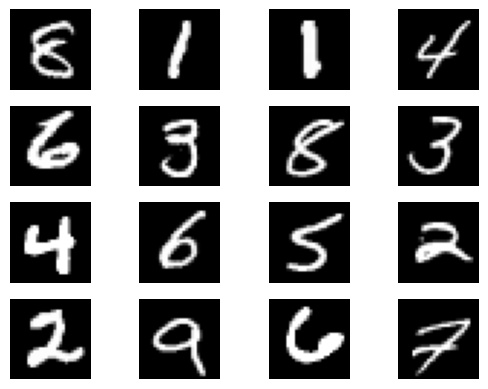

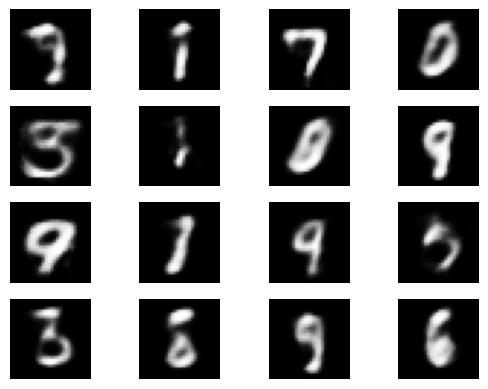

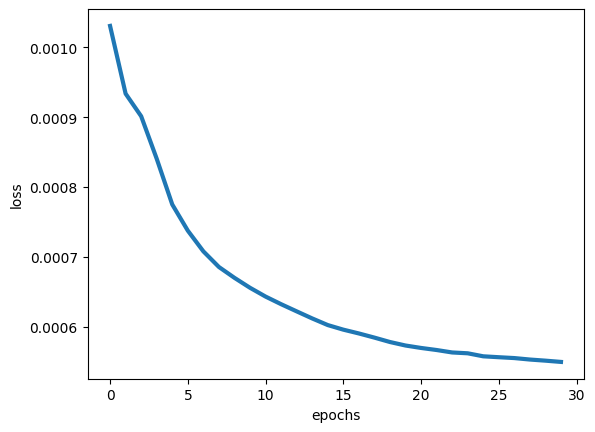

In [9]:
test_loss = f.evaluation(device, test_loader, name=result_dir+name)
file = open(result_dir+name + '_test_loss.txt', 'w')
file.write(str(test_loss))
file.close()

f.samples_real(result_dir + name, test_loader)
f.samples_generated(result_dir + name)

f.plot_curve(result_dir + name, nll_val)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

x_new = model.sample(1)
x = x_new.detach().cpu().numpy()
x = np.reshape(x, (28, 28))

plt.imshow(x, cmap='gray')
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)